# Titanic: Machine Learning from Disaster

* Description:
    The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.
* Problem definition: In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [2]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration

In [6]:
train = pd.read_csv('~/work/PresidentialTweets/tweets_train.csv')
test = pd.read_csv('~/work/PresidentialTweets/tweets_test.csv')

In [7]:
print ("Dimension of train data {}".format(train.shape))
print ("Dimension of test data {}".format(test.shape))

Dimension of train data (3999, 9)
Dimension of test data (2349, 11)


In [8]:
print ("Basic statistical description:")
train.describe()

Basic statistical description:


,id,retweet_count,favorite_count
count,3.999000e+03,3999.000000,3999.000000
mean,7.594926e+17,4964.529632,12911.969742
std,1.278198e+16,10017.445651,18009.926718
min,7.350000e+17,123.000000,415.000000
25%,7.500000e+17,1409.000000,3644.000000
50%,7.580000e+17,2980.000000,7537.000000
75%,7.700000e+17,6213.500000,17551.500000
max,7.810000e+17,490180.000000,660384.000000


#### We could know that the numbers of survived and died people are close to balanced.

# Comparison between test and train data

## From following cells, we could know that train and test data are split by PassengerId.

In [9]:
train.tail()

,id,handle,text,is_retweet,original_author,time,lang,retweet_count,favorite_count
3994,7.350000e+17,realDonaldTrump,"""@buiIdthewall: @realDonaldTrump high energy!""",False,NaN,2016-05-25T05:45:19,en,1984,8121
3995,7.350000e+17,realDonaldTrump,"""@PiperSul: Great speech tonight Mr.Trump! Goo...",False,NaN,2016-05-25T05:45:11,en,1827,7922
3996,7.350000e+17,realDonaldTrump,"""@DeepakS76435750: @realDonaldTrump congratula...",False,NaN,2016-05-25T05:42:59,en,1669,6868
3997,7.350000e+17,realDonaldTrump,"""@oasisupernova: @realDonaldTrump UP TO 8.4 MI...",False,NaN,2016-05-25T05:42:49,en,2684,9643
3998,7.350000e+17,realDonaldTrump,"""@jknatter: @realDonaldTrump #TrumpTrain""",False,NaN,2016-05-25T05:41:38,und,1165,5166


In [10]:
test.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,is_quote_status,lang,retweet_count,favorite_count
0,7.340000e+17,NaN,#MichaelBrown would have been 20 years old tod...,True,LSD_Esq,2016-05-20T18:07:08,NaN,False,en,594,1096
1,7.340000e+17,NaN,"Congratulations on becoming a U.S. citizen, Al...",False,NaN,2016-05-20T17:24:12,NaN,False,en,1701,4239
2,7.340000e+17,NaN,We need a president who will unite leaders aro...,False,NaN,2016-05-20T17:12:52,NaN,False,en,1817,3577
3,7.340000e+17,NaN,"Dear Congress,\n\nLet's get this done.\n\nThan...",False,NaN,2016-05-20T16:21:13,NaN,False,en,2530,6012
4,7.340000e+17,NaN,Failing @NYTimes will always take a good story...,False,NaN,2016-05-20T16:11:21,NaN,False,en,3750,12372


![title](input/features.png)

## Let's look at data graphically. We could see that all the distribution of features are similar.

[ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


AttributeError: 'DataFrame' object has no attribute 'Embarked'

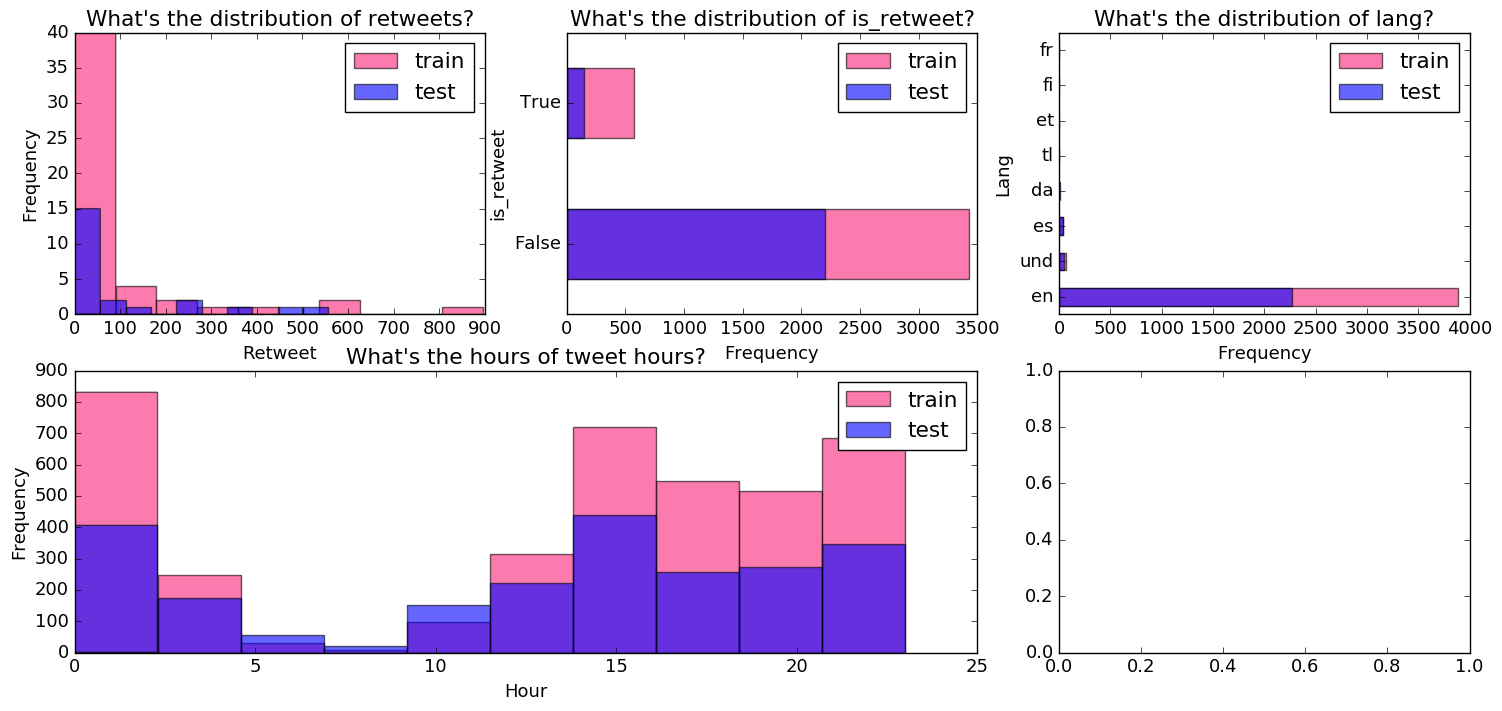

In [33]:
plt.rc('font', size=13)
fig = plt.figure(figsize=(18, 8))
alpha = 0.6

fixed_train = train.copy(False)
fixed_train['fixed_retweet'] = train['retweet_count'].map(lambda count: count//1000)

fixed_test = test.copy(False)
fixed_test['fixed_retweet'] = test['retweet_count'].map(lambda count: count//1000)

ax1 = plt.subplot2grid((2,3), (0,0))
fixed_train['fixed_retweet'].value_counts().plot(kind='hist', color='#FA2379', label='train', alpha=alpha)
fixed_test['fixed_retweet'].value_counts().plot(kind='hist', label='test', alpha=alpha)
ax1.set_xlabel('Retweet')
ax1.set_title("What's the distribution of retweets?" )
plt.legend(loc='best')

ax2 = plt.subplot2grid((2,3), (0,1))
train.is_retweet.value_counts().plot(kind='barh', color='#FA2379', label='train', alpha=alpha)
test.is_retweet.value_counts().plot(kind='barh', label='test', alpha=alpha)
ax2.set_ylabel('is_retweet')
ax2.set_xlabel('Frequency')
ax2.set_title("What's the distribution of is_retweet?" )
plt.legend(loc='best')

ax3 = plt.subplot2grid((2,3), (0,2))
train.lang.value_counts().plot(kind='barh', color='#FA2379', label='train', alpha=alpha)
test.lang.value_counts().plot(kind='barh', label='test', alpha=alpha)
ax3.set_ylabel('Lang')
ax3.set_xlabel('Frequency')
ax3.set_title("What's the distribution of lang?" )
plt.legend(loc='best')

import datetime
def their_time_to_p(time_s):
    return datetime.datetime.strptime(time_s, '%Y-%m-%dT%H:%M:%S')
fixed_train['fixed_time'] = train['time'].map(lambda time_s: their_time_to_p(time_s).hour)
fixed_test['fixed_time'] = test['time'].map(lambda time_s: their_time_to_p(time_s).hour)

a = fixed_train['fixed_time'].unique()
a.sort()
print(a)

ax4 = plt.subplot2grid((2,3), (1,0), colspan=2)
fixed_train['fixed_time'].value_counts().plot(kind='hist', color='#FA2379', label='train', alpha=alpha)
fixed_test['fixed_time'].value_counts().plot(kind='hist', label='test', alpha=alpha)
ax4.set_xlabel('Hour')
ax4.set_title("What's the distribution of tweet hours?" )
plt.legend(loc='best')

ax4 = plt.subplot2grid((2,3), (1,0), colspan=2)
fixed_train['fixed_time'].plot(kind='hist', color='#FA2379', label='train', alpha=alpha)
fixed_test['fixed_time'].plot(kind='hist', label='test', alpha=alpha)
ax4.set_xlabel('Hour')
ax4.set_title("What's the hours of tweet hours?" )
plt.legend(loc='best')

ax5 = plt.subplot2grid((2,3), (1,2))
train.Embarked.value_counts().plot(kind='barh', color='#FA2379', label='train', alpha=alpha)
test.Embarked.value_counts().plot(kind='barh', label='test', alpha=alpha)
ax5.set_ylabel('Embarked')
ax5.set_xlabel('Frequency')
ax5.set_title("What's the distribution of Embarked?" )
plt.legend(loc='best')
plt.tight_layout()

## Note: Comparision between test and train is important for detecting Class Leakage
## Class Lekage happens when the class you are trying to predict leaked the training features.

## We could know that the numbers of survived and died people are close to balanced.


In [8]:
print (train.Survived.value_counts())

0    549
1    342
Name: Survived, dtype: int64


## We will talk a bit on skewed datasets later

# Look closely to the train data

## We could see that the density of survived is higher than not survived under age 10.

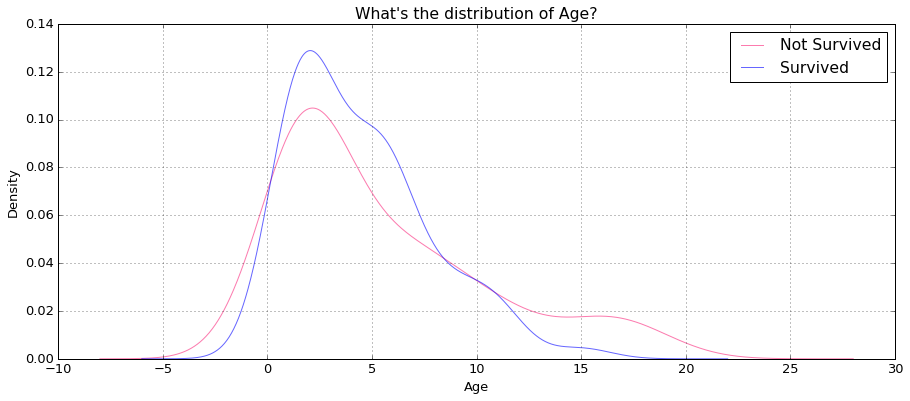

In [9]:
fig = plt.figure(figsize=(15, 6))

train[train.Survived==0].Age.value_counts().plot(kind='kde', color='#FA2379', label='Not Survived', alpha=alpha)
train[train.Survived==1].Age.value_counts().plot(kind='kde', label='Survived', alpha=alpha)
plt.xlabel('Age')
plt.title("What's the distribution of Age?" )
plt.legend(loc='best')
plt.grid()

#### We could observe that the survived rate of female is higher than male about 50%

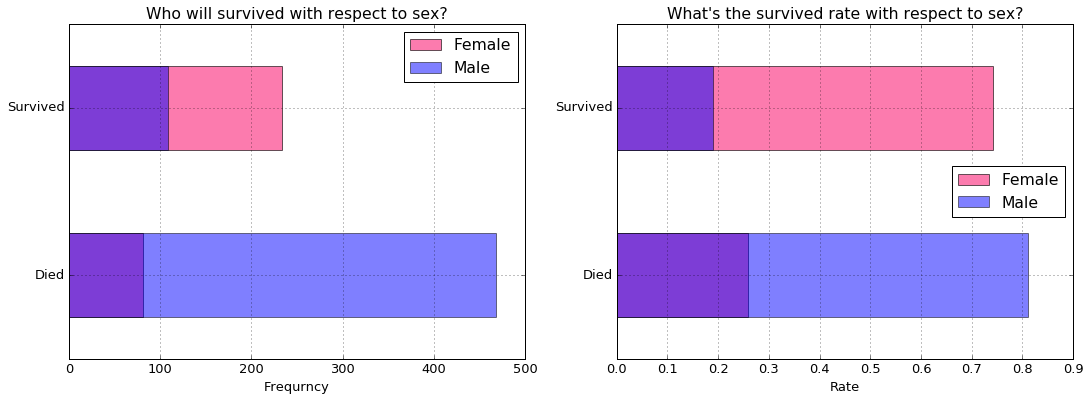

In [10]:
df_male = train[train.Sex=='male'].Survived.value_counts().sort_index()
df_female = train[train.Sex=='female'].Survived.value_counts().sort_index()
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot2grid((1,2), (0,0))
df_female.plot(kind='barh', color='#FA2379', label='Female', alpha=alpha)
df_male.plot(kind='barh', label='Male', alpha=alpha-0.1)
ax1.set_xlabel('Frequrncy')
ax1.set_yticklabels(['Died', 'Survived'])
ax1.set_title("Who will survived with respect to sex?" )
plt.legend(loc='best')
plt.grid()

ax2 = plt.subplot2grid((1,2), (0,1))
(df_female/train[train.Sex=='female'].shape[0]).plot(kind='barh', color='#FA2379', label='Female', alpha=alpha)
(df_male/train[train.Sex=='male'].shape[0]).plot(kind='barh', label='Male', alpha=alpha-0.1)
ax2.set_xlabel('Rate')
ax2.set_yticklabels(['Died', 'Survived'])
ax2.set_title("What's the survived rate with respect to sex?" )
plt.legend(loc='best')
plt.grid()

#### We could observed that the class of people affected the posibility of being survived.

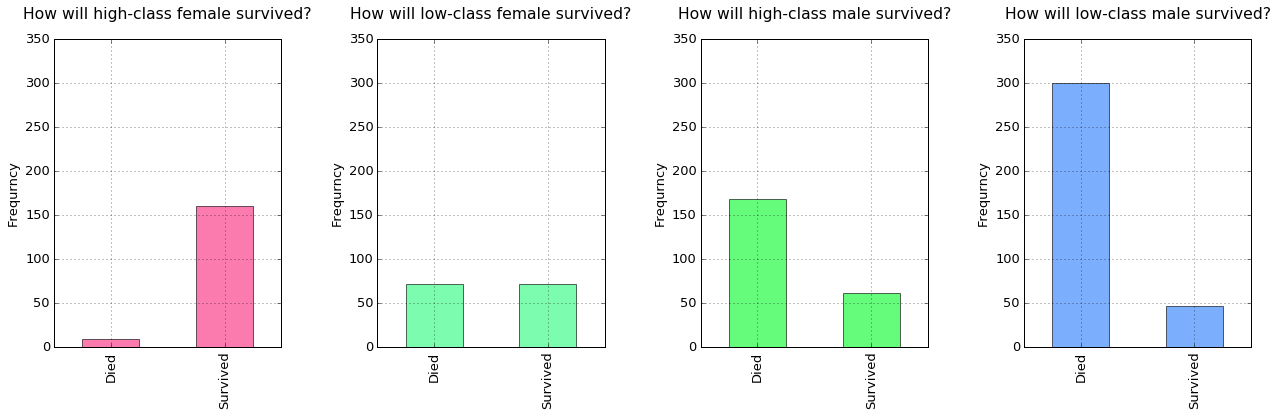

In [11]:
df_male = train[train.Sex=='male']
df_female = train[train.Sex=='female']
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot2grid((1,4), (0,0))
df_female[df_female.Pclass<3].Survived.value_counts().sort_index().plot(kind='bar', color='#FA2379', alpha=alpha)
ax1.set_ylabel('Frequrncy')
ax1.set_ylim((0,350))
ax1.set_xticklabels(['Died', 'Survived'])
ax1.set_title("How will high-class female survived?", y=1.05)
plt.grid()

ax2 = plt.subplot2grid((1,4), (0,1))
df_female[df_female.Pclass==3].Survived.value_counts().sort_index().plot(kind='bar', color='#23FA79', alpha=alpha)
ax2.set_ylabel('Frequrncy')
ax2.set_ylim((0,350))
ax2.set_xticklabels(['Died', 'Survived'])
ax2.set_title("How will low-class female survived?", y=1.05)
plt.grid()

ax3 = plt.subplot2grid((1,4), (0,2))
df_male[df_male.Pclass<3].Survived.value_counts().sort_index().plot(kind='bar', color='#00FA23', alpha=alpha)
ax3.set_ylabel('Frequrncy')
ax3.set_ylim((0,350))
ax3.set_xticklabels(['Died', 'Survived'])
ax3.set_title("How will high-class male survived?", y=1.05)
plt.grid()

ax4 = plt.subplot2grid((1,4), (0,3))
df_male[df_male.Pclass==3].Survived.value_counts().sort_index().plot(kind='bar', color='#2379FA', alpha=alpha)
ax4.set_ylabel('Frequrncy')
ax4.set_ylim((0,350))
ax4.set_xticklabels(['Died', 'Survived'])
ax4.set_title("How will low-class male survived?", y=1.05)
plt.grid()
plt.tight_layout()

#### We could see that if the value of Ticket is the same, passenger would be close, like friends or familes. But sometimes it will not be the case, so we need to carefully handle it.

In [12]:
train[train.Ticket=='1601']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In [13]:
train[train.Ticket=='CA 2144']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S
678,679,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S


# Data Cleaning

## Let's see how many missing values we have on each column. 

In [14]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Missing values on Embarked

## Let's assume the embarked is related with fare and pclass.

,Fare,Pclass,Embarked
61,80.0,1,NaN
829,80.0,1,NaN


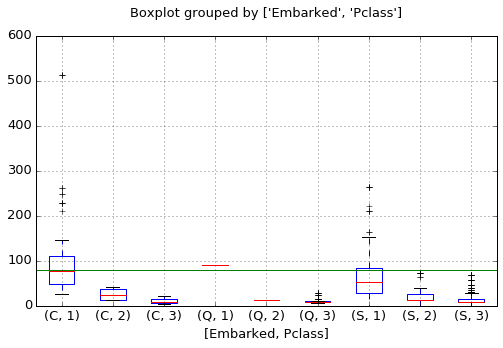

In [16]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax = train.boxplot(column='Fare', by=['Embarked','Pclass'], ax=ax)
plt.axhline(y=80, color='green')
ax.set_title('', y=1.1)

train[train.Embarked.isnull()][['Fare', 'Pclass', 'Embarked']]

## From the above boxplot, we should replace NA with C because most people who had Pclass 1 and Fare 80 would be Embarked C

In [17]:
_ = train.set_value(train.Embarked.isnull(), 'Embarked', 'C')

## Missing values on Fare

## By fixing the values of Embarked and Pclass, we could plot histogram of Fare. And we should use the most common value to replace the NA value of Fare.

,Pclass,Fare,Embarked
152,3,NaN,S


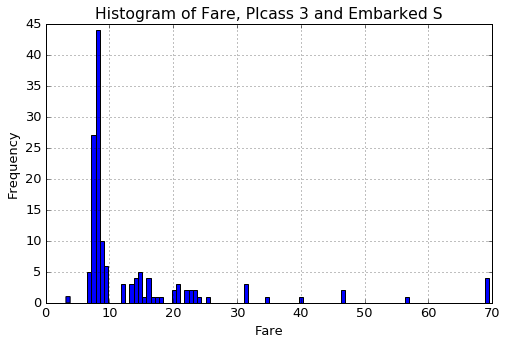

In [18]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
test[(test.Pclass==3)&(test.Embarked=='S')].Fare.hist(bins=100, ax=ax)
test[test.Fare.isnull()][['Pclass', 'Fare', 'Embarked']]
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fare, Plcass 3 and Embarked S')

test[test.Fare.isnull()][['Pclass', 'Fare', 'Embarked']]

In [19]:
print ("The top 5 most common value of Fare")
test[(test.Pclass==3)&(test.Embarked=='S')].Fare.value_counts().head()

The top 5 most common value of Fare


8.0500    17
7.8958    10
7.7750    10
8.6625     8
7.8542     8
Name: Fare, dtype: int64

In [20]:
_ = test.set_value(test.Fare.isnull(), 'Fare', 8.05)

# Replace the missing value of Cabin with U0

In [21]:
full = pd.concat([train, test], ignore_index=True)
_ = full.set_value(full.Cabin.isnull(), 'Cabin', 'U0')

# Feature Engineering

## Create a feature, Names, to store the length of words in name.

In [22]:
import re
names = full.Name.map(lambda x: len(re.split(' ', x)))
_ = full.set_value(full.index, 'Names', names)
del names

## Create a feature, Title.
### Is there a different between: Miss, Mrs? Master, Mr?

In [23]:
title = full.Name.map(lambda x: re.compile(', (.*?)\.').findall(x)[0])
title[title=='Mme'] = 'Mrs'
title[title.isin(['Ms','Mlle'])] = 'Miss'
title[title.isin(['Don', 'Jonkheer'])] = 'Sir'
title[title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'
title[title.isin(['Capt', 'Col', 'Major', 'Dr', 'Officer', 'Rev'])] = 'Officer'
_ = full.set_value(full.index, 'Title', title)
del title

## Create a feature, Deck. It may represents the socioeconomic status.

### (For exmple We have Deck value, map it: C20 ->  C. Use  factorize to change into enumarate categorical variable)

In [24]:
deck = full[~full.Cabin.isnull()].Cabin.map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
deck = pd.factorize(deck)[0]
_ = full.set_value(full.index, 'Deck', deck)

del deck

## Create a feature, Room. It may represents the geo lacation.

In [25]:
checker = re.compile("([0-9]+)")
def roomNum(x):
    nums = checker.search(x)
    if nums:
        return int(nums.group())+1
    else:
        return 1
rooms = full.Cabin.map(roomNum)
_ = full.set_value(full.index, 'Room', rooms)

del checker, roomNum

## Create a feature, Group_num. It may represents the size of family.

In [26]:
full['Group_num'] = full.Parch + full.SibSp + 1

## Create a feature, Group_size. When the size is between 2 and 4, more people are survived.

In [27]:
full['Group_size'] = pd.Series('M', index=full.index)
_ = full.set_value(full.Group_num>4, 'Group_size', 'L')
_ = full.set_value(full.Group_num==1, 'Group_size', 'S')

## Normalized the fare.

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
full['NorFare'] = pd.Series(scaler.fit_transform(full.Fare.values.reshape(-1,1)).reshape(-1), index=full.index)

In [29]:
def setValue(col):
    _ = train.set_value(train.index, col, full[:891][col].values)
    _ = test.set_value(test.index, col, full[891:][col].values)

for col in ['Deck', 'Room', 'Group_size', 'Group_num', 'Names', 'Title']:
    setValue(col)

## How should we fill Age NaN? Predict Age

In [30]:
full.drop(labels=['PassengerId', 'Name', 'Cabin', 'Survived', 'Ticket', 'Fare'], axis=1, inplace=True)

In [31]:
full = pd.get_dummies(full, columns=['Embarked', 'Sex', 'Title', 'Group_size'])

## Create dataset

In [34]:
from sklearn.model_selection import train_test_split
X = full[~full.Age.isnull()].drop('Age', axis=1)
y = full[~full.Age.isnull()].Age
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##  Gridsearch Parameters

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

def get_model(estimator, parameters, X_train, y_train, scoring):  
    model = GridSearchCV(estimator, param_grid=parameters, scoring=scoring)
    model.fit(X_train, y_train)
    return model.best_estimator_

In [36]:
import xgboost as xgb

XGB = xgb.XGBRegressor(max_depth=4, seed= 42)
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
parameters = {'reg_alpha':np.linspace(0.1,1.0,5), 'reg_lambda': np.linspace(1.0,3.0,5)}
reg_xgb = get_model(XGB, parameters, X_train, y_train, scoring)
print (reg_xgb)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0.55000000000000004,
       reg_lambda=3.0, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)


In [37]:
print ("Mean absolute error of test data: {}".format(mean_absolute_error(y_test, reg_xgb.predict(X_test))))

Mean absolute error of test data: 7.72831093144


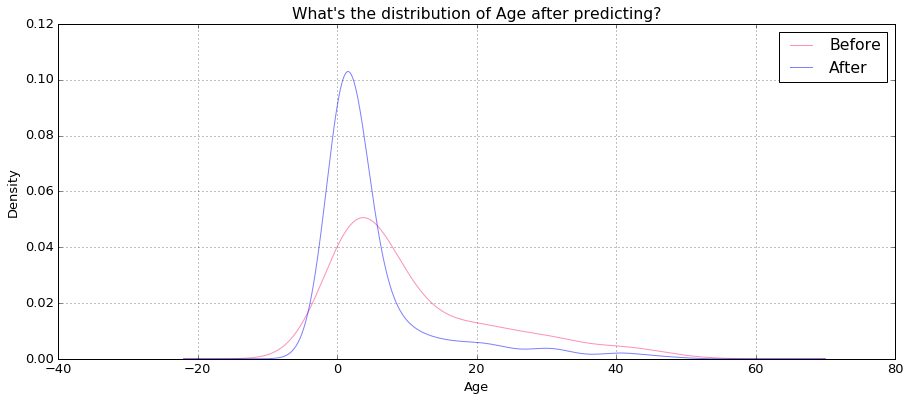

In [38]:
fig = plt.figure(figsize=(15, 6))
alpha = 0.5
full.Age.value_counts().plot(kind='density', color='#FA2379', label='Before', alpha=alpha)

pred = reg_xgb.predict(full[full.Age.isnull()].drop('Age', axis=1))
full.set_value(full.Age.isnull(), 'Age', pred)

full.Age.value_counts().plot(kind='density', label='After', alpha=alpha)
plt.xlabel('Age')
plt.title("What's the distribution of Age after predicting?" )
plt.legend(loc='best')
plt.grid()

In [39]:
full['NorAge'] = pd.Series(scaler.fit_transform(full.Age.values.reshape(-1,1)).reshape(-1), index=full.index)
full['NorNames'] = pd.Series(scaler.fit_transform(full.Names.values.reshape(-1,1)).reshape(-1), index=full.index)
full['Group_num'] = pd.Series(scaler.fit_transform(full.Group_num.values.reshape(-1,1)).reshape(-1), index=full.index)

/Users/idschwartz/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [40]:
for col in ['NorAge', 'NorFare', 'NorNames', 'Group_num']:
    setValue(col)

### Encoding sex, feamle: 0 and male: 1

In [41]:
train.Sex = np.where(train.Sex=='female', 0, 1)
test.Sex = np.where(test.Sex=='female', 0, 1)

# Convert values of Embarked and Ticket into dummy variables

In [42]:
train.drop(labels=['PassengerId', 'Name', 'Names', 'Cabin', 'Ticket', 'Age', 'Fare'], axis=1, inplace=True)
test.drop(labels=['Name', 'Names', 'Cabin', 'Ticket', 'Age', 'Fare'], axis=1, inplace=True)

In [43]:
train = pd.get_dummies(train, columns=['Embarked', 'Pclass', 'Title', 'Group_size'])
test = pd.get_dummies(test, columns=['Embarked', 'Pclass', 'Title', 'Group_size'])
test['Title_Sir'] = pd.Series(0, index=test.index)

## Build Model

## Plotting learning curve function

In [44]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring,
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [45]:
X = train.drop(['Survived'], axis=1)
y = train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
from sklearn.metrics import accuracy_score
scoring = make_scorer(accuracy_score, greater_is_better=True)

## Gaussian Naive Bayes

In [47]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
parameters = {}
clf_gnb = get_model(GNB, parameters, X_train, y_train, scoring)

0.780269058296
GaussianNB(priors=None)


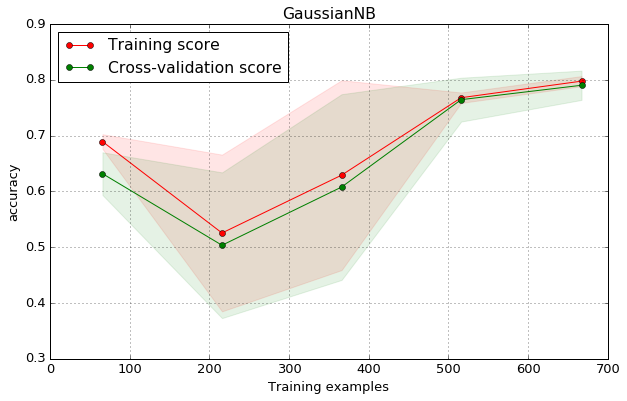

In [48]:
print (accuracy_score(y_test, clf_gnb.predict(X_test)))
print (clf_gnb)
plot_learning_curve(clf_gnb, 'GaussianNB', X, y, cv=4);

## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, criterion='entropy', min_samples_split=5, oob_score=True)
parameters = {'n_estimators':[500], 'min_samples_leaf':[12], 'n_jobs':[5]}
clf_rfc1 = get_model(rfc, parameters, X_train, y_train, scoring)

0.829596412556
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=12,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=5, oob_score=True, random_state=42,
            verbose=0, warm_start=False)


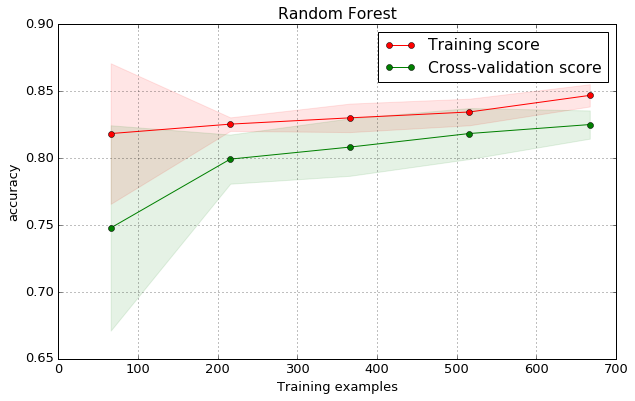

In [52]:
print (accuracy_score(y_test, clf_rfc1.predict(X_test)))
print (clf_rfc1)
plot_learning_curve(clf_rfc1, 'Random Forest', X, y, cv=4);

## Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state=42, penalty='l2')
parameters = {'C':[25]}
clf_lg1 = get_model(lg, parameters, X_train, y_train, 'accuracy')

LogisticRegression(C=25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.811659192825


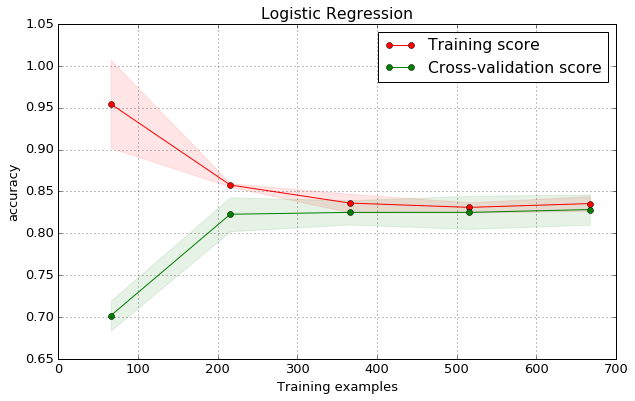

In [50]:
print (clf_lg1)
print (accuracy_score(y_test, clf_lg1.predict(X_test)))
plot_learning_curve(clf_lg1, 'Logistic Regression', X, y, cv=4);

# Feature Selection 

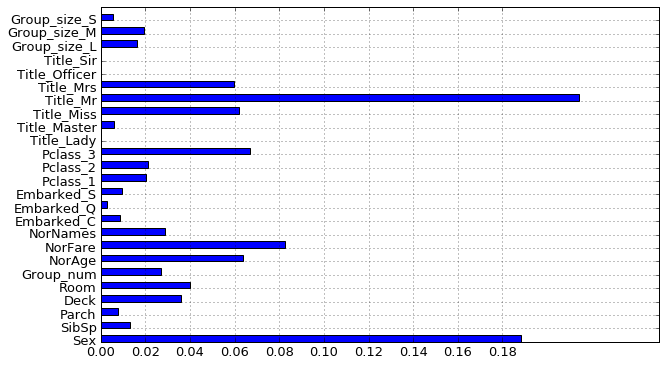

In [53]:
plt.figure(figsize=(10,6))
plt.barh(np.arange(X_train.columns.shape[0]), clf_rfc1.feature_importances_, 0.5)
plt.yticks(np.arange(X_train.columns.shape[0]), X_train.columns)
plt.grid()
plt.xticks(np.arange(0,0.2,0.02));

In [54]:
cols = X_train.columns[clf_rfc1.feature_importances_>=0.006]

In [55]:
lr = LogisticRegression(random_state=42, penalty='l2')
parameters = {'C':[0.1]}
clf_lr2 = get_model(lr, parameters, X_train[cols], y_train, scoring)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.820627802691


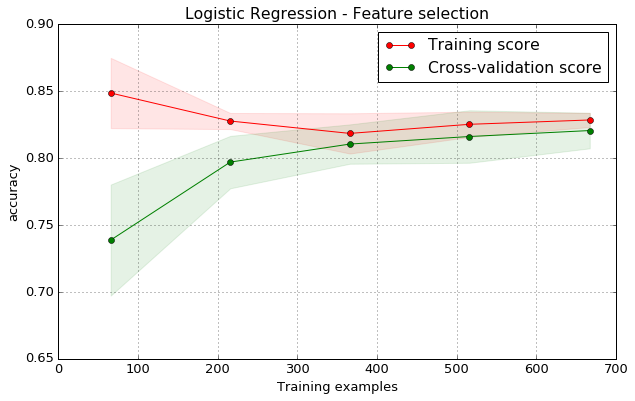

In [56]:
print (clf_lr2)
print (accuracy_score(y_test, clf_lr2.predict(X_test[cols])))
plot_learning_curve(clf_lr2, 'Logistic Regression - Feature selection', X[cols], y, cv=4);

### SVC

In [57]:
from sklearn.svm import SVC
svc = SVC(random_state=47, kernel='poly', probability=True)
parameters = {'C': [25], 'gamma': [0.0055], 'coef0': [0.1],
              'degree':[2]}
clf_svc = get_model(svc, parameters, X_train, y_train, scoring)

SVC(C=25, cache_size=200, class_weight=None, coef0=0.1,
  decision_function_shape=None, degree=2, gamma=0.0055, kernel='poly',
  max_iter=-1, probability=True, random_state=47, shrinking=True,
  tol=0.001, verbose=False)
0.816143497758


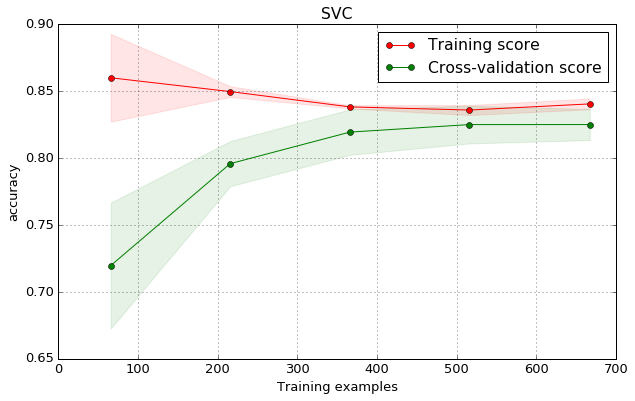

In [58]:
print (clf_svc)
print (accuracy_score(y_test, clf_svc.predict(X_test)))
plot_learning_curve(clf_svc, 'SVC', X, y, cv=4);

### XGBoost

In [59]:
import xgboost as XGB
xgb = XGB.XGBClassifier(seed=42, max_depth=3, objective='binary:logistic', n_estimators=400)
parameters = {'learning_rate':[0.1],
              'reg_alpha':[3.0], 'reg_lambda': [4.0]}
clf_xgb1 = get_model(xgb, parameters, X_train, y_train, scoring)

0.820627802691
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=3.0, reg_lambda=4.0,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)


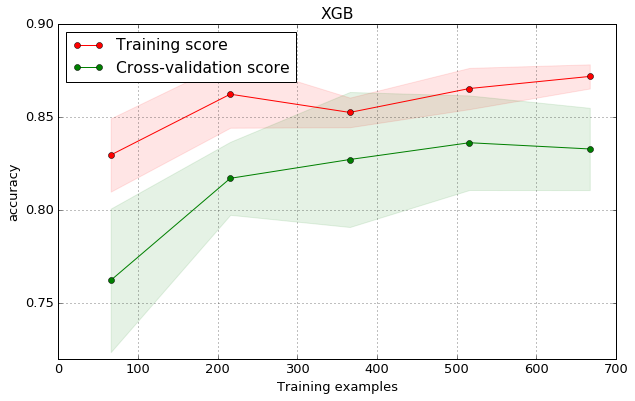

In [60]:
print (accuracy_score(y_test, clf_xgb1.predict(X_test)))
print (clf_xgb1)
plot_learning_curve(clf_xgb1, 'XGB', X, y, cv=4);

## Ensemble

In [61]:
from sklearn.ensemble import VotingClassifier
clf_vc = VotingClassifier(estimators=[('xgb1', clf_xgb1), ('lg1', clf_lg1), ('svc', clf_svc), 
                                      ('rfc1', clf_rfc1),('lr2', clf_lr2), ('gnb', clf_gnb)], 
                          voting='soft', weights=[4,1,1,1,1,2])
clf_vc = clf_vc.fit(X_train, y_train)

0.834080717489
VotingClassifier(estimators=[('xgb1', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=3.0, reg_lambda=4.0,
    ...='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None))],
         n_jobs=1, voting='soft', weights=[4, 1, 1, 1, 1, 2])


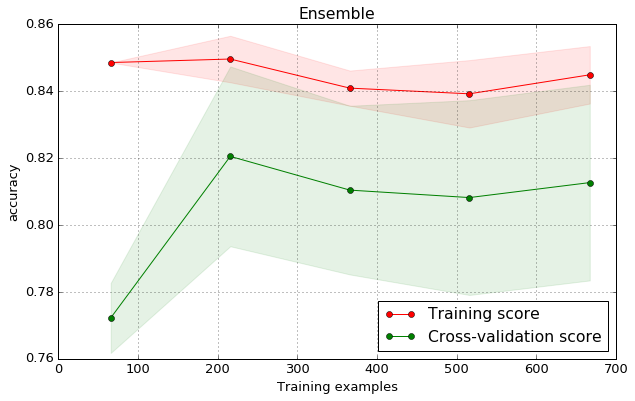

In [62]:
print (accuracy_score(y_test, clf_vc.predict(X_test)))
print (clf_vc)
plot_learning_curve(clf_vc, 'Ensemble', X, y, cv=4);

# AUC

In [63]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(estimator, X, y, title):
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(y, estimator.predict_proba(X)[:,1])

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print ('ROC AUC: %0.2f' % roc_auc)

    # Plot of a ROC curve for a specific class
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

ROC AUC: 0.90


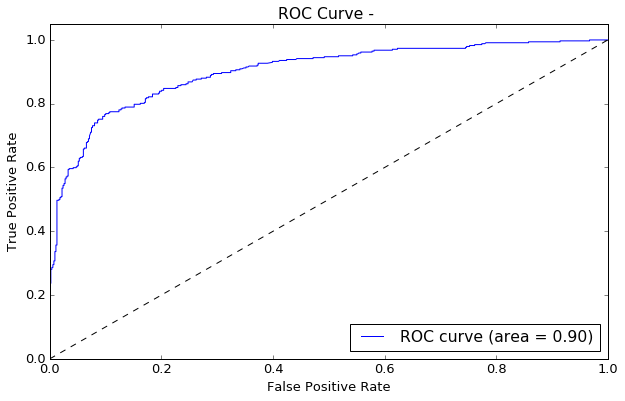

In [64]:
plot_roc_curve(clf_vc,X,y,"")